In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from operator import itemgetter

import progressbar

import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [3]:
data_list_raw = read_data('../data/input/GO/merged/')

#raw data
print data_list_raw[0]
print len(data_list_raw)

data_list = []
for each in data_list_raw:
    sent = set(map(itemgetter(1), each))
    if len(sent) != 1:
        data_list.append(each)
    
#clean data
print data_list[0]
print len(data_list)


# data_list = data_list[:3000]

train_test_cutoff = int(.70 * len(data_list)) 
training_sentences = data_list[:train_test_cutoff]
testing_sentences = data_list[train_test_cutoff:]
 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'GO:0010467'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O')]
9571
[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'GO:0010467'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O')]
9571


In [4]:
print training_sentences[0]

[('Regulation', 'GO:0065007'), ('of', 'O'), ('Muscle', 'O'), ('Fiber', 'O'), ('Type', 'O'), ('and', 'O'), ('Running', 'O'), ('Endurance', 'O'), ('by', 'O'), ('PPAR\xce\xb4', 'O')]


In [5]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
 
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """

    term = sentence_terms[index]

    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [6]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 
 
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]
 
def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
 
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
 
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

In [7]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [8]:
from sklearn.feature_extraction import DictVectorizer
 
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [9]:
# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

In [10]:
# Fit LabelEncoder with our list of classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

In [11]:
from sklearn.utils import class_weight
import numpy as np

class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [12]:
# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [13]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape
print X_val.shape, y_val.shape

(121783, 66108) (71871, 66108) (121783, 359) (71871, 359)
(41567, 66108) (41567, 359)


In [14]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation

# with tf.device('/gpu:1'):
#     x = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]))
#     model = Sequential()
#     model.add(Dense(512, input_shape=(X_train.shape[1],), init='normal', activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(512, input_shape=(X_train.shape[1],), init='normal', activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(y_train.shape[1], activation='softmax'))

#     print model.summary()
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train, y_train, validation_data = (X_val, y_val), nb_epoch=5,
#                         batch_size=100, verbose=1, )
    

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
 
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, init='normal', input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons, init='normal'),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
 
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
 
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 1024,
    'output_dim': y_train.shape[1],
    'epochs': 15,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'class_weight': 'auto',
    'shuffle': True
}
 
clf = KerasClassifier(**model_params)

In [17]:
history = clf.fit(X_train, y_train)

/home/sdmohant/.virtualenvs/deeplearn/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="normal", input_dim=66108)`
  if __name__ == '__main__':
/home/sdmohant/.virtualenvs/deeplearn/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="normal")`
  if sys.path[0] == '':


Train on 121783 samples, validate on 41567 samples
Epoch 1/15
121783/121783 [==============================] - 117s 960us/step - loss: 0.6484 - acc: 0.9411 - val_loss: 0.2404 - val_acc: 0.9695
Epoch 2/15
121783/121783 [==============================] - 106s 870us/step - loss: 0.1041 - acc: 0.9803 - val_loss: 0.1813 - val_acc: 0.9737
Epoch 3/15
121783/121783 [==============================] - 101s 830us/step - loss: 0.0587 - acc: 0.9867 - val_loss: 0.1794 - val_acc: 0.9732
Epoch 4/15
121783/121783 [==============================] - 101s 826us/step - loss: 0.0445 - acc: 0.9897 - val_loss: 0.1892 - val_acc: 0.9713
Epoch 5/15
121783/121783 [==============================] - 101s 828us/step - loss: 0.0381 - acc: 0.9915 - val_loss: 0.1943 - val_acc: 0.9723
Epoch 6/15
121783/121783 [==============================] - 101s 827us/step - loss: 0.0331 - acc: 0.9925 - val_loss: 0.1861 - val_acc: 0.9738
Epoch 7/15
121783/121783 [==============================] - 101s 828us/step - loss: 0.0322 - acc:

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
 
    green = '#72C29B'
    orange = '#FFA577'
 
    plt.style.use("ggplot")
    # plot model loss
    fig, ax1 = plt.subplots()
    ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=5,
             label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
             linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    # plot model accuracy
    fig, ax2 = plt.subplots()
    ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=5,
             label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
             linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)

In [20]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_merged_Window_Based.tsv', sep='\t')

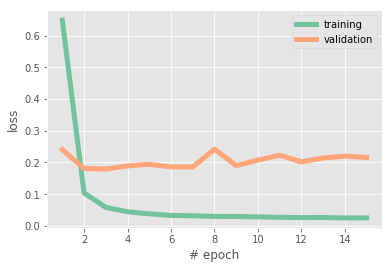

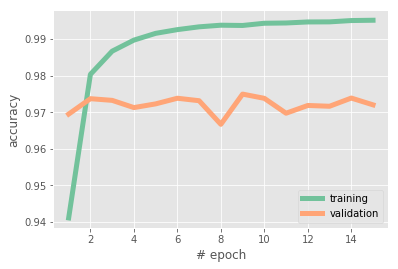

In [21]:
# Plot model performance
plot_model_performance(
    train_loss=history.history.get('loss', []),
    train_acc=history.history.get('acc', []),
    train_val_loss=history.history.get('val_loss', []),
    train_val_acc=history.history.get('val_acc', [])
)

In [22]:
from sklearn.metrics import classification_report


predicted = clf.predict(X_test)
predicted_cat = np_utils.to_categorical(predicted)
report = classification_report(y_test, predicted_cat, target_names=label_encoder.classes_)
print "\n"
print report

71871/71871 [==============================] - 40s 563us/step


                        precision    recall  f1-score   support

            GO:0000003       0.47      0.42      0.45       106
            GO:0000075       0.00      0.00      0.00         0
            GO:0000237       0.00      0.00      0.00         0
            GO:0000238       0.00      0.00      0.00         0
            GO:0000239       0.00      0.00      0.00         0
            GO:0000240       0.00      0.00      0.00         0
            GO:0000267       0.00      0.00      0.00        18
            GO:0000279       0.00      0.00      0.00         0
            GO:0000502       0.00      0.00      0.00         0
            GO:0000718       0.00      0.00      0.00         0
            GO:0000732       0.00      0.00      0.00        39
            GO:0000775       0.00      0.00      0.00         0
            GO:0000785       0.90      1.00      0.95         9
            GO:0000786       0.00      

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
print predicted, X_test

[357 357 357 ... 357 357 357] [[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [24]:
print y_test

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [25]:
import numpy as np


y_test_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
y_pred_classes = [np.argmax(y, axis=None, out=None) for y in predicted_cat]

p = label_encoder.inverse_transform(y_test_classes)
t = label_encoder.inverse_transform(y_pred_classes)

print p
print t

['O' 'O' 'O' ... 'O' 'O' 'O']
['O' 'O' 'O' ... 'O' 'O' 'O']


/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
# from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# cnf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_, title='Confusion matrix, without normalization')

In [27]:
df = pd.DataFrame(
{
    'Predicted' : p,
    'Ground Truth': t
}
)

In [28]:
df.to_csv('../data/results/GO_merged_Window_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/GO_merged_Window_Based.tsv ../data/validation_data/GO_AllSubsumers.tsv

Mean semantic similarity:  0.608
